In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Value Class

In [4]:
class Value:

    def __init__(self, data, _children = (), _operation = "", label = ""):
        self.data = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        prev = (self, other)
        operation = "+"
        result = Value(self.data + other.data, _children = prev, _operation = operation)
        return result

    def __mul__(self, other):
        prev = (self, other)
        operation = " x "
        result = Value(self.data * other.data, _children = prev, _operation = operation)
        return result

    def __sub__(self, other):
        prev = (self, other)
        operation = " - "
        result = Value(self.data - other.data, _children = prev, _operation = operation)
        return result

    def tanh(self):
        x = self.data
        prev = (self,)
        operation = "tanh(n)"
        tan_h = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        return Value(tan_h, prev, operation)

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir":"LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._operation, label=n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

In [6]:
a = Value(3.0, label = "a")
b = Value(5.0, label = "b")
c = Value(-2.0, label = "c")

d = a * b; d.label = "d"

e = c + d; e.label = "e"

f = Value(10.0, label = "f")

L = e * f; L.label = "L"

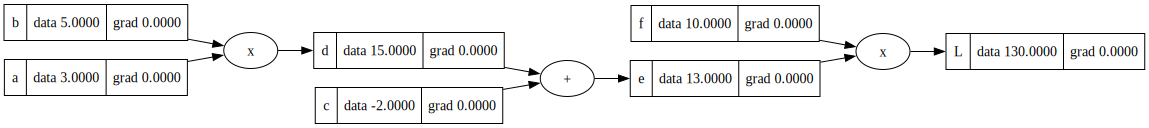

In [7]:
draw_dot(L)

# Manual Back Propagation example 1

as you can see here the graph represents how L is created by mini values

What we need to do is we need to find grad of each value according to L.

dL / dL - derivation of L according to L

dL / df - derivation of L according to f

dL / de - derivation of L according to e

dL / dc - derivation of L according to c

dL / dd - derivation of L according to d

dL / da - derivation of L according to a

dL / db - derivation of L according to b

here I am going to use chain rule to find some values. Here is the chain rule

f(u) = u and u = x + 1. What I need to do is I need to find df(u)/dx

so the solution is: df(u)/dx = (df(u)/du) * (du/dx) <- this is chain rule

dL / dL = 1

(f(x + h) - f(x)) / h

(L + h - L) / h = h / h = 1.0

In [8]:
L.grad = 1.0

dL / df

L = e x f

(f(x + h) - f(x)) / h

(f(e x (f + h)) - e x f) / h = (e x f + e x h - e x f) / h = (e x h) / h = e

so dL / df = e

e = 13.0

In [9]:
f.grad = 13.0

dL / de

L = e x f

(f(x + h) - f(x)) / h

(f((e + h) x f) - e x f) / h = (e x f + f x h - e x f) / h = (f x h) / h = f

so dL / de = f

f = 10.0

In [10]:
e.grad = 10.0

dL / dc <- The chain rule is stared here. One of main part of Newural Nets

dL / dc = (dL / de)  x  (de / dc) here as I said I used chain rule. If you do not understand it look at Manual Backpropagation example 1 explanation. 

dL / de = 10.0 <- I calculated earlier

de / dc = ?

(f(x + h) - f(x)) / h

(c + d + h - (c + d)) / h = h / h = 1.0

so (dL / de)  x  (de / dc) = 10.0 x 1.0 = 10.0

In [11]:
c.grad = 10.0

dL / dd

dL / dd = (dL / de)  x  (de / dd)

dL / de = 10.0 <- I calculated earlier

de / dd = ?

(f(x + h) - f(x)) / h

(c + d + h - (c + d)) / h = h / h = 1.0

so (dL / de)  x  (de / dd) = 10.0 x 1.0 = 10.0

In [12]:
d.grad = 10.0

dL / da <- a bit more advansed chain rule is applied

dL / da = dL / de x de / dd x dd/da <- very complex hah ? I spend 1 week to understand it actually. 

dL / de = 10.0

de / dd = 10.0

dd / da = ?

(f(x + h) - f(x)) / h

((a + h) x b - a x b) / h = (a x b + h x b - a x b) / h = b

b = 5.0

dL / da = dL / de x de / dd x dd/da = 10.0 x 5.0

dL / da = 50.0

In [13]:
a.grad = 50.0

dL / db <- a bit more advansed chain rule is applied

dL / db = dL / de x de / dd x dd/db

dL / de = 10.0

de / dd = 10.0

dd / db = ?

(f(x + h) - f(x)) / h

(a x (b + h) - a x b) / h = (a x b + h x a - a x b) / h = a

a = 3.0

dL / db = dL / de x de / dd x dd/db = 10.0 x 3.0

dL / db = 30.0

In [14]:
b.grad = 30.0

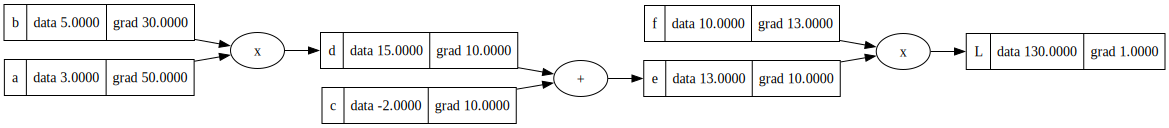

In [15]:
draw_dot(L)

# Manual Back Propagation example 2 with tanh

in this example we age going to use real artficial neuron. you can see the photo of artificial neuron by following link 
https://cs231n.github.io/assets/nn1/neuron_model.jpeg

In [16]:
x1 = Value(2.3, label = "x1")
x2 = Value(1.9, label = "x2")

w1 = Value(2.52, label = "w1")
w2 = Value(1.11, label = "w2")

b = Value(0.29, label = "b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label = "o"

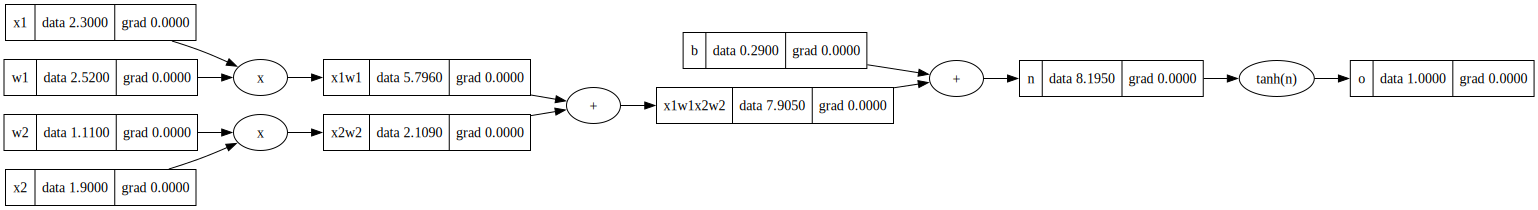

In [17]:
draw_dot(o)

I need to took derivations, as you know. We are going to use the chain rule here also.

dO / dO - derivation according to dO

dO / dn - derivation according to n

dO / db - derivation according to b

dO / d(x1w1x2w2) - derivation according to x1w1x2w2

dO / d(x1w1) - derivation according to x1w1

dO / d(x2w2) - derivation according to x2w2

dO / d(x1) - derivation according to x1

dO / d(w1) - derivation according to w1

dO / d(x2) - derivation according to x2

dO / d(w1) - derivation according to w2

dO / dO I need to find now.

dO / dO = 1

In [18]:
o.grad = 1.0

In [19]:
n.grad = 0.9999997

In [20]:
b.grad = 0.9999997

In [21]:
x1w1x2w2.grad = 0.9999997

In [22]:
x1w1.grad = 0.9999997

In [23]:
x2w2.grad = 0.9999997

In [24]:
x1.grad = 0.9999997 * 2.52

In [25]:
w1.grad = 0.9999997 * 2.3

In [26]:
x2.grad = 0.9999997 * 1.11

In [27]:
w2.grad = 0.9999997 * 1.9

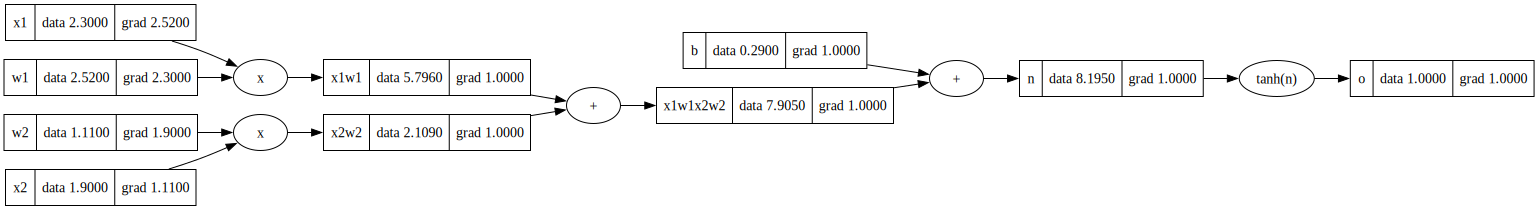

In [28]:
draw_dot(o)